# All SPCs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

from sklearn.decomposition import PCA

## Helper functions

In [4]:
def check_gaussianity(data_points, title="",plotto=1):
	if str(type(data_points)) == "<class 'pandas.core.series.Series'>":
		data_points = data_points.dropna().values
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		plt.hist(data_points)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{title}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({title}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	print('H0 is "data are not gaussian" => conclusion is good if pvalue is high')

def check_randomness(data_points, title="", plotto=1, layout="h"):
	if plotto==1:
		if layout=="v":
			fig, ax = plt.subplots(3,1, figsize=(8,12))
		else:
			fig, ax = plt.subplots(1,3, figsize=(12,4))
		sgt.plot_acf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[0])
		fig.subplots_adjust(hspace=0.3)
		sgt.plot_pacf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[1], method = 'ywm')
		ax[2].plot(data_points,'o-')
		plt.show()	
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({title}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')
	print('H0 is "data are random" => conclusion is good if pvalue is high')

def check_residuals(model):
	fig, axs = plt.subplots(2, 2, figsize=(12,7))
	fig.suptitle('Residual Plots')
	stats.probplot(model.resid, dist="norm", plot=axs[0,0])
	axs[0,0].set_title('Normal probability plot')
	axs[0,1].scatter(model.fittedvalues, model.resid)
	axs[0,1].set_title('Versus Fits')
	axs[1,0].hist(model.resid)
	axs[1,0].set_title('Histogram')
	axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
	_, pval_SW_res = stats.shapiro(model.resid)
	plt.subplots_adjust(hspace=0.3) 
	check_randomness(model.resid,title="residuals")
	check_gaussianity(model.resid,title="residuals",plotto=0)

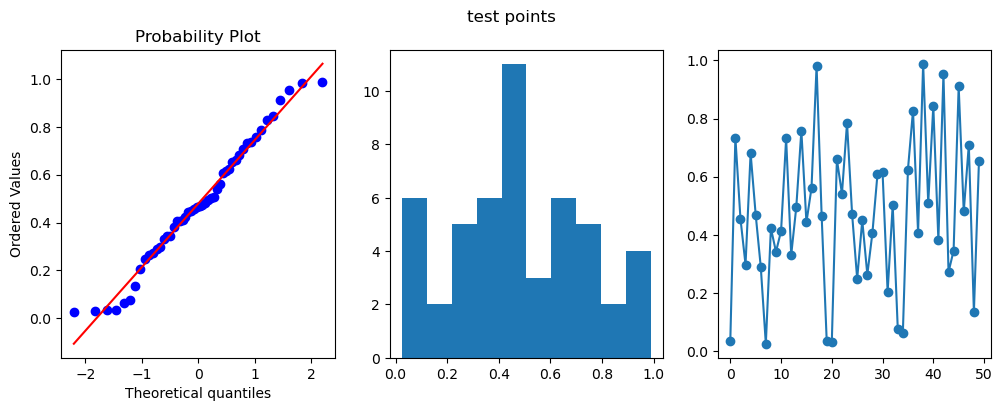

(test points) Normality p-value = 0.29300132393836975 - Normality at alpha 5%? True
H0 is "data are not gaussian" => conclusion is good if pvalue is high


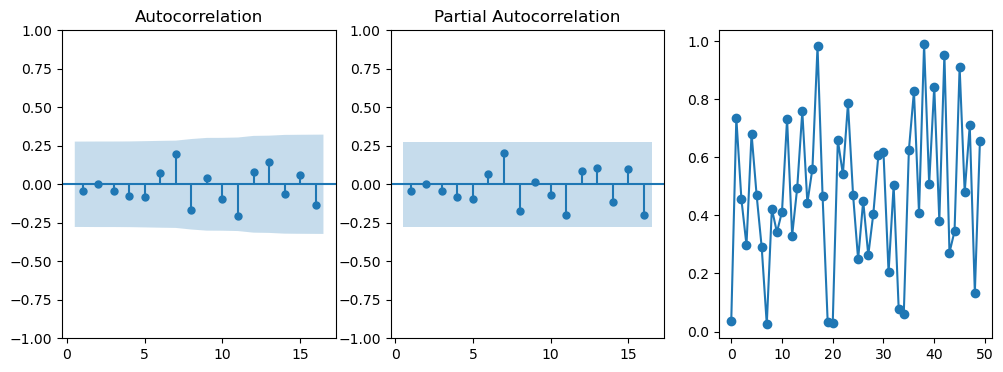

(test points) Runs test p-value = 0.963290720540952 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high


In [75]:
vals = np.random.rand(50)
check_gaussianity(vals,title="test points",plotto=1)
check_randomness(vals,title="test points",plotto=1,layout="h")

## Python utilities
In uppercase the parts that should be changed, according to the specific use context.

In [ ]:
# Import the dataset
df = pd.read_csv('PATH/TO/FILE.CSV')
df.head()

# Stack data into single column
data_stack = df.stack() 

# standardize the data
data_std = (df - df.mean()) / df.std()

# Break single column data in different samples (ie batching)
m=10 # number of samples
n=4  # observations in each sample
df=np.array(df['COLUMN']).reshape(m,n)
df=pd.DataFrame(df)
df.head()

# Change all columns names
new_columns = ['new_col1', 'new_col2', 'new_col3']
df.columns = new_columns
# Change specific columns names
df = df.rename(columns={'col1': 'new_col1', 'col2': 'new_col2'})

# When axis=0 is specified, the operation is performed along the rows (i.e., column by column).
# When axis=1 is specified, the operation is performed along the columns (i.e., row by row).

# ■ SPC iid (Lab 6)

<!-- ## XbarR -->
## Case n>1
<!-- Used for the case n>1 with estimated parameters.   -->
So here data.head() will give a matrix of data, where each row is a sample, and inside each row there are the n observations for that sample.

In [87]:
data = pd.read_csv("./Lab6/ESE06_ex1.csv")
data.head()

,x1,x2,x3,x4,x5
0,10.10,10.04,10.13,9.98,10.14
1,10.28,10.13,9.78,9.94,9.83
2,9.95,10.36,9.90,9.96,9.96
3,9.88,9.89,9.98,9.74,10.14
4,10.12,9.83,10.14,9.81,9.86


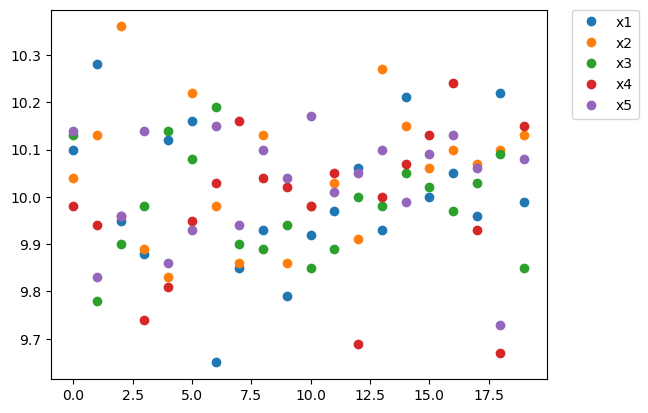

In [88]:
# Scatter plot of all the columns against the index
plt.plot(data['x1'], linestyle='none', marker='o', label = 'x1')
plt.plot(data['x2'], linestyle='none', marker='o', label = 'x2')
plt.plot(data['x3'], linestyle='none', marker='o', label = 'x3')
plt.plot(data['x4'], linestyle='none', marker='o', label = 'x4')
plt.plot(data['x5'], linestyle='none', marker='o', label = 'x5')
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

1. There should not be strange patterns or outliers (otherwise go to SPC non iid section), between the samples (so going horizontally morally) and witihin the samples (so checking vertically).  
2. We might also check randomness **but** we would need to know the within-sample order!  
If we knew it we can just stack the data and check randomness assumption on the big vector generated.
3. So we just check normality, on all data points (ie stacking them, getting the big vector mentioned also in point 2).

### Box Cox
If we dont have normality we transform the data using Box Cox.
$$x_{BC,i} = \left\{ \begin{array}{ll} \frac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\ \ln x_i & \text{if } \lambda = 0 \end{array} \right.$$

Lambda = 7.058


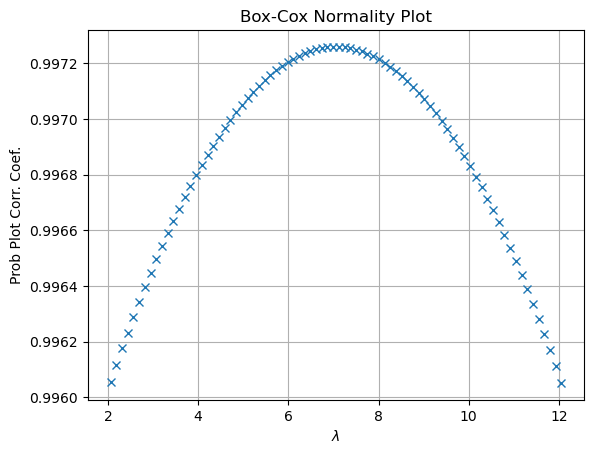

In [98]:
data_stack = data.stack()

# Box-Cox transformation and return the transformed data
[data_BC, lmbda] = stats.boxcox(data_stack)
print('Lambda = %.3f' % lmbda)
# Use this if we want to set the lambda manually
# data_BC = stats.boxcox(data_stack, lmbda=CHOSEN_VALUE)

# Use this to find the best value of lambda for the transformation
fig = plt.figure()
ax = fig.add_subplot(111)
stats.boxcox_normplot(data_stack, lmbda-5, lmbda+5, plot=ax)
ax.grid(True)

# Come back to the original structure of the dataset, ie unstack the data
data_BC_unstack = data_BC.reshape(data.shape)
# and convert it to a DataFrame
data_BC = pd.DataFrame(data_BC_unstack, columns = data.columns)

### XbarR

In [ ]:
# Create the control chart with the data
data_XR = qda.ControlCharts.XbarR(data)

# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
data_XR_alpha = qda.ControlCharts.XbarR(data, K = K_alpha)

### Manually
 **$\mathbf{\bar{X}}$ chart**:
 - $UCL = \overline{\overline{X}} + z_{\alpha/2} \frac{1}{d_2 \sqrt{n}} \overline{R}$
 - $CL = \overline{\overline{X}}$
 - $LCL = \overline{\overline{X}} - z_{\alpha/2} \frac{1}{d_2 \sqrt{n}} \overline{R}$

 **$R$ chart**:
 - $UCL = \overline{R} + z_{\alpha/2} \frac{d_3}{d_2} \overline{R}$
 - $CL = \overline{R}$
 - $LCL = max(0;\ \overline{R} - z_{\alpha/2} \frac{d_3}{d_2} \overline{R})$

      x1     x2     x3    x4     x5  sample_mean  sample_range
0  10.10  10.04  10.13  9.98  10.14       10.078          0.16
1  10.28  10.13   9.78  9.94   9.83        9.992          0.50
2   9.95  10.36   9.90  9.96   9.96       10.026          0.46
3   9.88   9.89   9.98  9.74  10.14        9.926          0.40
4  10.12   9.83  10.14  9.81   9.86        9.952          0.33
Mean of the sample mean: 10.008
Mean of the sample range: 0.314


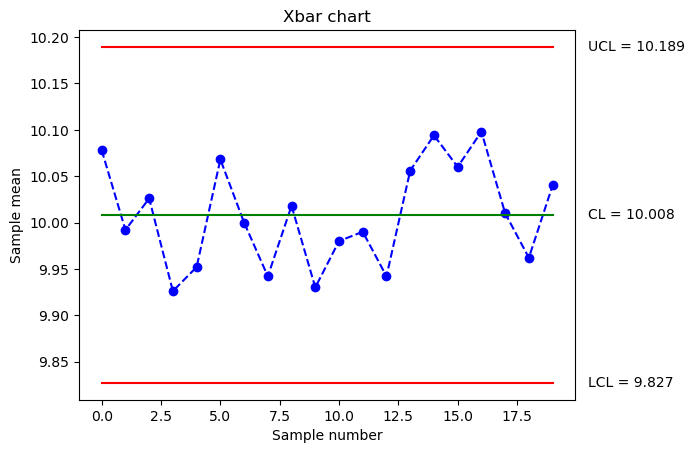

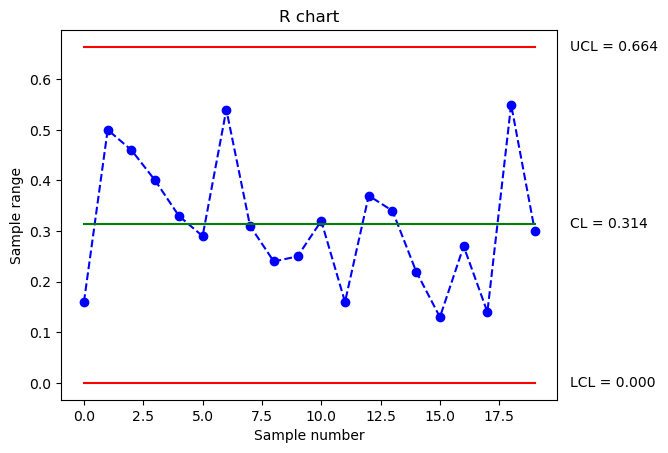

In [43]:
# Make a copy of the data
data_XR = data.copy()
# Add a column with the mean of the rows
data_XR['sample_mean'] = data.mean(axis=1)
# Add a column with the range of the rows
data_XR['sample_range'] = data.max(axis=1) - data.min(axis=1)

# Inspect the dataset
print(data_XR.head())

Xbar_mean = data_XR['sample_mean'].mean() # grand mean
R_mean = data_XR['sample_range'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % R_mean)

alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)

# Vd tabella alla fine per valori
n = 5
A2 = 0.577
D3 = 0
D4 = 2.114

# Now we can compute the CL, UCL and LCL for Xbar and R
data_XR['Xbar_CL'] = Xbar_mean
data_XR['Xbar_UCL'] = Xbar_mean + A2 * R_mean
data_XR['Xbar_LCL'] = Xbar_mean - A2 * R_mean

data_XR['R_CL'] = R_mean
data_XR['R_UCL'] = D4 * R_mean
data_XR['R_LCL'] = D3 * R_mean

data_XR['Xbar_TEST1'] = np.where((data_XR['sample_mean'] > data_XR['Xbar_UCL']) | 
                (data_XR['sample_mean'] < data_XR['Xbar_LCL']), data_XR['sample_mean'], np.nan)
data_XR['R_TEST1'] = np.where((data_XR['sample_range'] > data_XR['R_UCL']) | 
                (data_XR['sample_range'] < data_XR['R_LCL']), data_XR['sample_range'], np.nan)

# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XR['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['Xbar_UCL'], color='r')
plt.plot(data_XR['Xbar_CL'], color='g')
plt.plot(data_XR['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the R chart
plt.title('R chart')
plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['R_UCL'], color='r')
plt.plot(data_XR['R_CL'], color='g')
plt.plot(data_XR['R_LCL'], color='r')
plt.ylabel('Sample range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

### Estimate variance and CI
Variance estimate trhough R:
$$\hat{\sigma} = \frac{\bar{R}}{d_2(n)}$$
CI: $$\bar{X} - z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{n}} \leq \mu \leq \bar{X} + z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{n}}$$

In [45]:
# Estimate sigma_hat through R statistic
d2 = qda.constants.getd2(n) # to get d2
sigma_hat = R_mean / d2
print('Sigma_hat = %.3f' % sigma_hat)

# Estimate confidence interval (control limits) 
CI = stats.norm.interval(1-alpha, loc=Xbar_mean, scale=sigma_hat/np.sqrt(n))
print('CI = (%.3f, %.3f)' % CI)

Sigma_hat = 0.135
CI = (9.822, 10.195)


### Table of constants

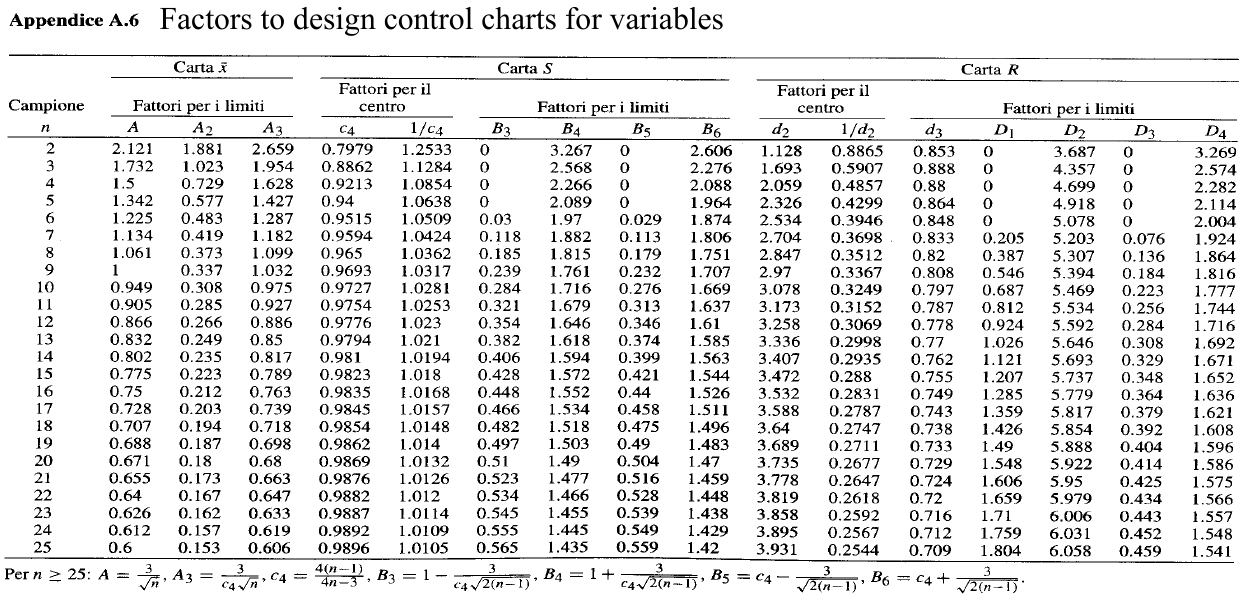

### Operating characteristic curve
$$\beta = P(Z \leq K - \delta \sqrt{n}) - P(Z \leq -K - \delta \sqrt{n})$$

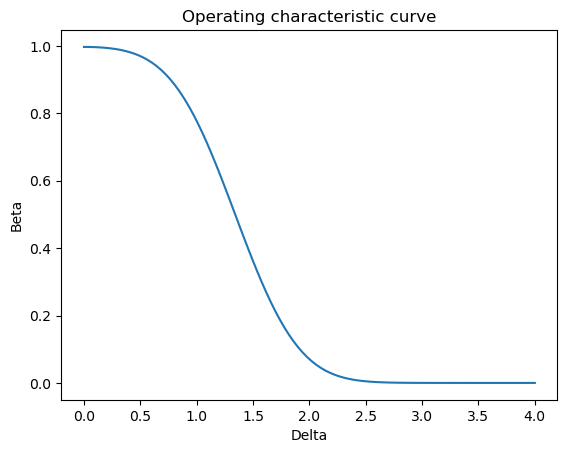

In [41]:
# n=data.shape[1] # maybe this also work
n=SET_N_FROM_DATA
# Define a range of values for beta
delta = np.linspace(0, 4, 100)
# Compute the corresponding beta values
beta = stats.norm.cdf(3 - delta*np.sqrt(n)) - stats.norm.cdf(-3 - delta*np.sqrt(n))
# Plot the beta values
plt.plot(delta, beta)
plt.xlabel('Delta')
plt.ylabel('Beta')
plt.title('Operating characteristic curve')
plt.show()

### ARL curve
ARL is the expected number of samples that we need to wait (on average) before identifying that the process had a shift.
$$ARL = \frac{1}{1-\beta}$$

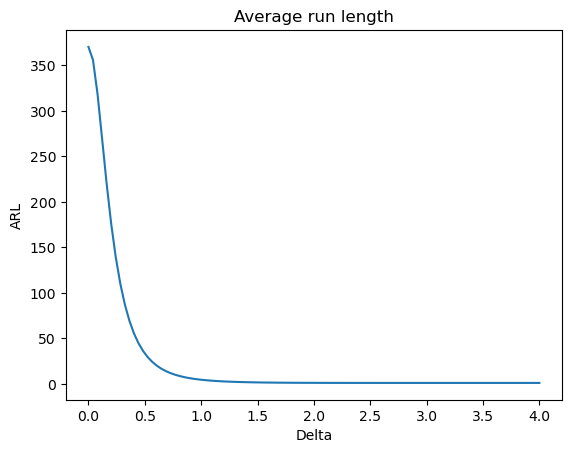

In [34]:
# Average run length ARL
ARL = 1/(1-beta)
# Plot the ARL values
plt.plot(delta, ARL)
plt.xlabel('Delta')
plt.ylabel('ARL')
plt.title('Average run length')
plt.show()

### XbarS

In [ ]:
# X-bar and S charts
data_XS = qda.ControlCharts.XbarS(data)

# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
data_XR_alpha = qda.ControlCharts.XbarS(data, K = K_alpha)

### Manually

      x1     x2     x3    x4     x5  sample_mean  sample_std
0  10.10  10.04  10.13  9.98  10.14       10.078    0.067231
1  10.28  10.13   9.78  9.94   9.83        9.992    0.209690
2   9.95  10.36   9.90  9.96   9.96       10.026    0.188361
3   9.88   9.89   9.98  9.74  10.14        9.926    0.147241
4  10.12   9.83  10.14  9.81   9.86        9.952    0.163615
Mean of the sample mean: 10.008
Mean of the sample range: 0.130


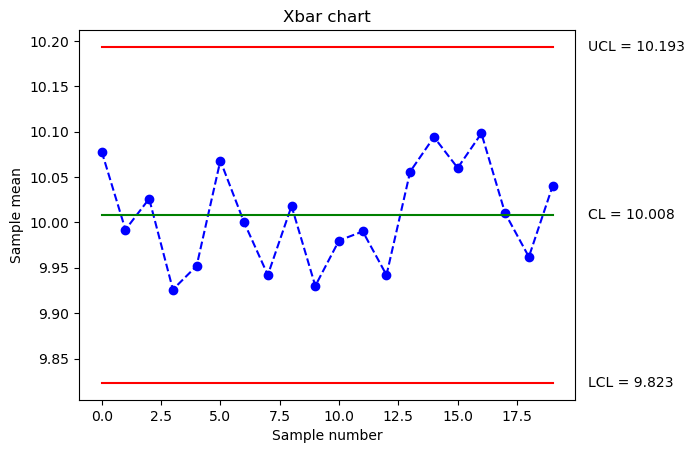

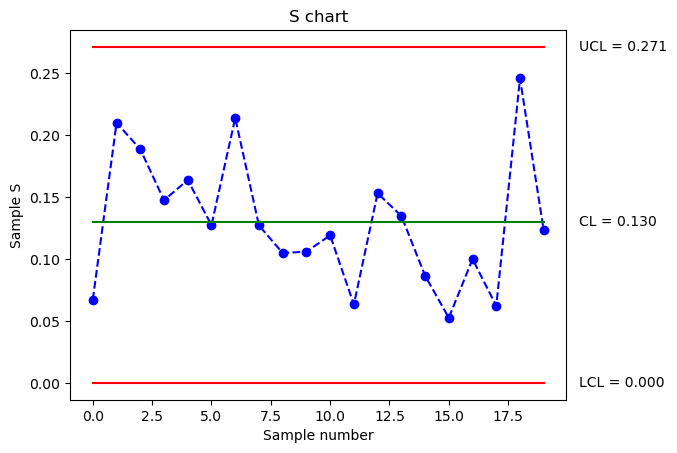

In [47]:
# Make a copy of the data
data_XS = data.copy()
# Add a column with the mean of the rows
data_XS['sample_mean'] = data.mean(axis=1)
# Add a column with the range of the rows
data_XS['sample_std'] = data.std(axis=1)

print(data_XS.head())

Xbar_mean = data_XS['sample_mean'].mean()
S_mean = data_XS['sample_std'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % S_mean)

n = data.shape[1]
K = 3
A3 = K * 1 / (qda.constants.getc4(n) * np.sqrt(n))
B3 = np.maximum(1 - K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n)), 0)
B4 = 1 + K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n))

# Now we can compute the CL, UCL and LCL for Xbar and S
data_XS['Xbar_CL'] = Xbar_mean
data_XS['Xbar_UCL'] = Xbar_mean + A3 * S_mean
data_XS['Xbar_LCL'] = Xbar_mean - A3 * S_mean
data_XS['S_CL'] = S_mean
data_XS['S_UCL'] = B4 * S_mean
data_XS['S_LCL'] = B3 * S_mean
data_XS['Xbar_TEST1'] = np.where((data_XS['sample_mean'] > data_XS['Xbar_UCL']) | 
                (data_XS['sample_mean'] < data_XS['Xbar_LCL']), data_XS['sample_mean'], np.nan)
data_XS['S_TEST1'] = np.where((data_XS['sample_std'] > data_XS['S_UCL']) | 
                (data_XS['sample_std'] < data_XS['S_LCL']), data_XS['sample_std'], np.nan)
data_XS.head()

# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XS['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['Xbar_UCL'], color='r')
plt.plot(data_XS['Xbar_CL'], color='g')
plt.plot(data_XS['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the S chart
plt.title('S chart')
plt.plot(data_XS['sample_std'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['S_UCL'], color='r')
plt.plot(data_XS['S_CL'], color='g')
plt.plot(data_XS['S_LCL'], color='r')
plt.ylabel('Sample S')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['S_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['S_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['S_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['S_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['S_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

## Case n=1
So no we deal with individual data.

In [106]:
data = pd.read_csv("./Lab6/ESE06_ex3.csv")
COL_NAME = "GM"
data.head()

,GM
0,-0.875
1,2.437
2,-1.187
3,-2.063
4,0.938


1. Verify randomness assumption.
2. Verify normality assumption.

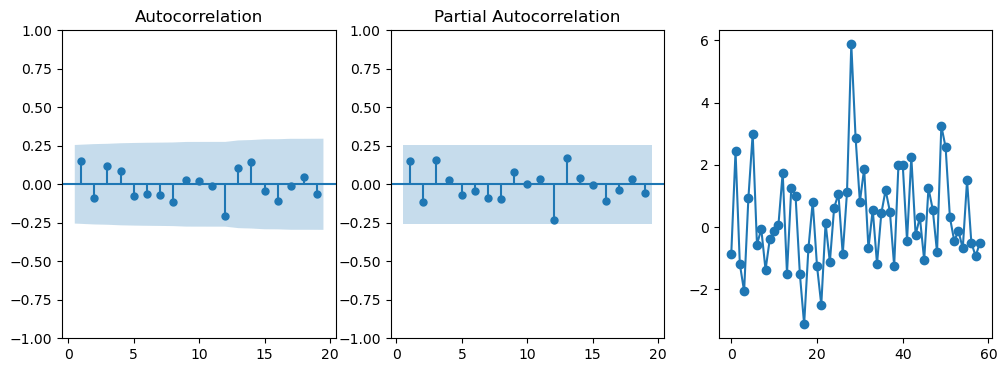

() Runs test p-value = 0.8793778294331255 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high


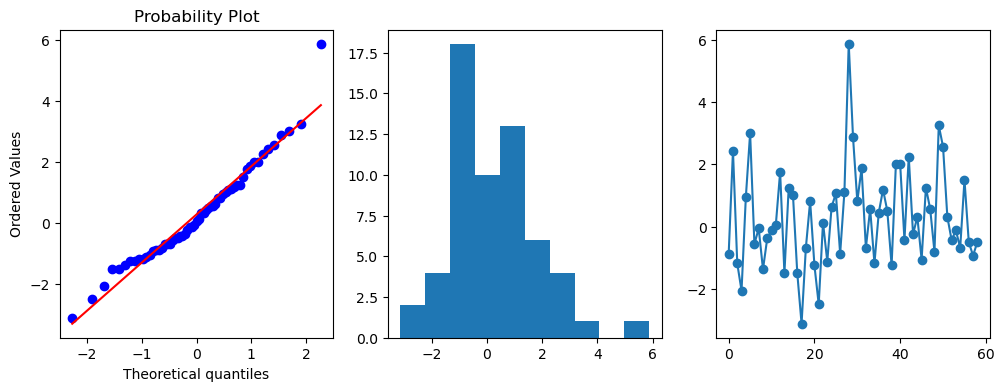

() Normality p-value = 0.06757929176092148 - Normality at alpha 5%? True
H0 is "data are not gaussian" => conclusion is good if pvalue is high


In [107]:
check_randomness(data[COL_NAME])
check_gaussianity(data[COL_NAME])

### IMR

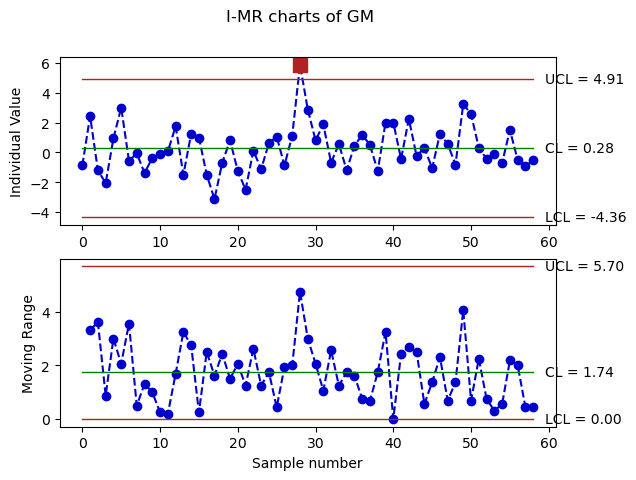

In [108]:
data_IMR = qda.ControlCharts.IMR(data, COL_NAME)

### MR variants
The MR follows a half Normal distribution, so those classical limits could not suit it very well. In that case we could
1. switch to probability limits by using the half-normal approximation (morally a always correct choice)
> - $UCL = D_{1-\alpha/2} \frac{\bar{MR}}{d_2}$
> - $LCL = D_{\alpha/2} \frac{\bar{MR}}{d_2}$
>
> For $n=2$ (Alwan, Appendix A):
> - $D_{1-\alpha/2} = \sqrt{2} z_{alpha/4}$
> - $D_{\alpha/2} = \sqrt{2} z_{1/2 - alpha/4}$

In [109]:
alpha = 0.01
K_alpha = stats.norm.ppf(1-alpha/2)

MR_UCL = 6.1342
MR_LCL = 0.0137


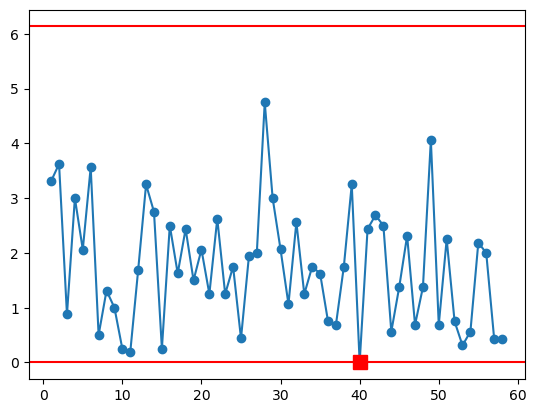

In [110]:
data['MR'] = data[COL_NAME].diff().abs()
D_UCL = np.sqrt(2) * stats.norm.ppf(1-alpha/4)
D_LCL = np.sqrt(2) * stats.norm.ppf(1 - (1/2 - alpha/4))

MR_UCL = D_UCL * data_IMR['MR'].mean()/qda.constants.getd2(2)
MR_LCL = D_LCL * data_IMR['MR'].mean()/qda.constants.getd2(2)

print('MR_UCL = %.4f' % MR_UCL)
print('MR_LCL = %.4f' % MR_LCL)

data_IMR['MR_TEST1'] = np.where((data_IMR['MR'] > MR_UCL) | 
                                (data_IMR['MR'] < MR_LCL), data_IMR['MR'], np.nan)

plt.plot(data_IMR['MR'], 'o-')
plt.axhline(MR_UCL, color = 'r')
plt.axhline(MR_LCL, color = 'r')
plt.plot(data_IMR['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

2. transform the variable with Box Cox and use on them the I chart
> We know we can apply a known transformation ($\lambda = 0.4$).   
> Attention: Box-Cox is not directly applicable to MR data because we have an observation equal to 0. 

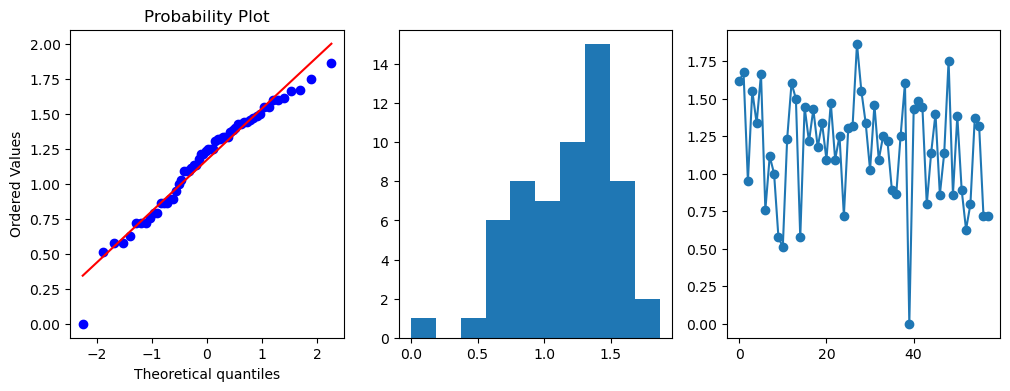

() Normality p-value = 0.11422736942768097 - Normality at alpha 5%? True
H0 is "data are not gaussian" => conclusion is good if pvalue is high


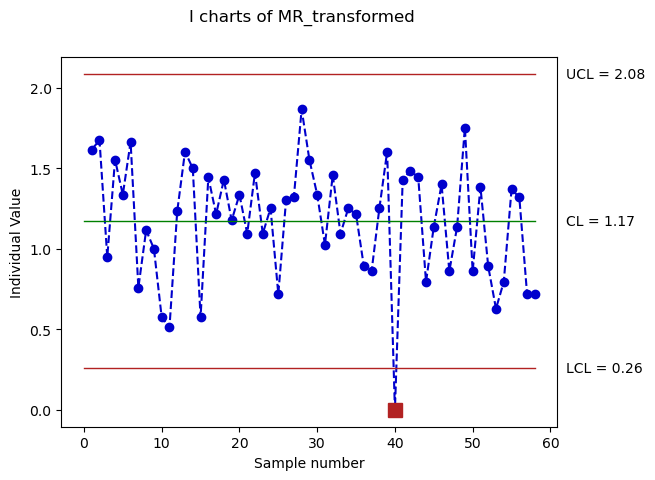

In [113]:
# Extract the 'MR' column   
MR = pd.DataFrame(data_IMR['MR'])
# Get the index of the value equal to 0
idx = MR[MR['MR'] == 0].index[0]
# Change it to NaN
MR['MR'].iloc[idx] = np.nan

# Transform the data
MR['MR'] = MR['MR'].transform(lambda x: ((x**0.4)))
# or with Box Cox (?)
# [data_BC, lmbda] = stats.boxcox(MR['MR'])
# MR['MR'] = data_BC

# Replace the NaN value with 0
MR['MR'].iloc[idx] = 0

check_gaussianity(MR['MR'])
# Now use the classical I chart

# Change the name of the column in MR to 'MR_transformed'
MR = MR.rename(columns = {'MR': 'MR_transformed'})
data_MR_transformed = qda.ControlCharts.IMR(MR, 'MR_transformed', K = K_alpha, plotit = False)

# Plot the I chart with the transformed data
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I charts of MR_transformed'))
ax.plot(data_MR_transformed['MR_transformed'], color='mediumblue', linestyle='--', marker='o')
ax.plot(data_MR_transformed['I_UCL'], color='firebrick', linewidth=1)
ax.plot(data_MR_transformed['I_CL'], color='g', linewidth=1)
ax.plot(data_MR_transformed['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(data_MR_transformed['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_CL'].iloc[0], 'CL = {:.2f}'.format(data_MR_transformed['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(data_MR_transformed['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(data_MR_transformed['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()

### Manually

Now we can proceed with the charts.  
 **I chart**:
 - $UCL = \bar{x} + 3 \left(\frac{\bar{MR}}{d_2} \right)$
 - $CL = \bar{x}$
 - $LCL = \bar{x} - 3 \left(\frac{\bar{MR}}{d_2} \right)$
 
 **MR chart**:
 - $UCL = D_4 \bar{MR}$
 - $CL = \bar{MR}$
 - $LCL = 0$

       I     MR
0 -0.875    NaN
1  2.437  3.312
2 -1.187  3.624
3 -2.063  0.876
4  0.938  3.001
       I     MR     I_UCL      I_CL     I_LCL    MR_UCL     MR_CL  MR_LCL  \
0 -0.875    NaN  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
1  2.437  3.312  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
2 -1.187  3.624  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
3 -2.063  0.876  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
4  0.938  3.001  4.912667  0.275424 -4.361819  5.696352  1.743603       0   

   I_TEST1  MR_TEST1  
0      NaN       NaN  
1      NaN       NaN  
2      NaN       NaN  
3      NaN       NaN  
4      NaN       NaN  


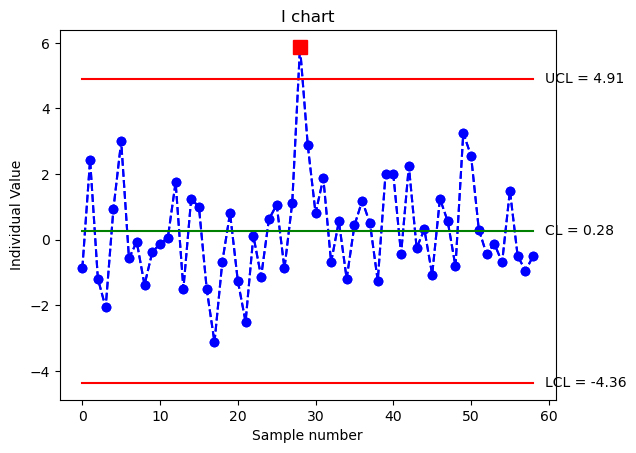

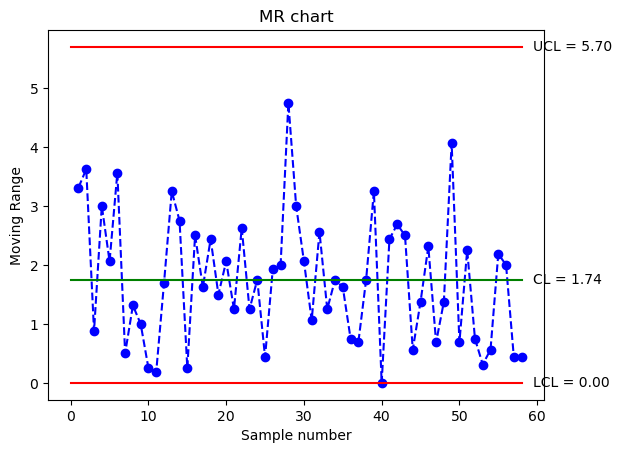

In [57]:
# Compute the moving ranges using the diff function
data['MR'] = data[COL_NAME].diff().abs()
# Print out descriptive statistics of MR and time
# data.describe()

# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

print(df.head())

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

### OOC signaled
What to do?  
- if we have an assignable cause: the data violating the charts was really out of control, so we should remove it and redesign the chart (as phase 1 assumes to be working only with in control data). 
- if no assignable cause: do nothing, it was a false alarm. It can happen. In case we want really to remove it we can tune the alpha, ie the K defining the widht of the charts. Otherwise that is in any case the final chart.

In [60]:
# find the index of the I_TEST1 column different from NaN -> ooc value index
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]

print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: [28]


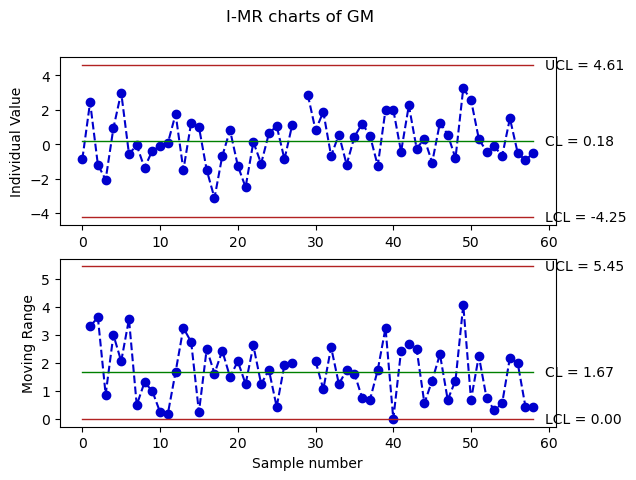

In [64]:
# New control chart without ooc value
# only if assignable cause, iterative procedure
data_2 = data.copy()
# replace the OOC point with NaN
data_2[COL_NAME].iloc[OOC_idx] = np.nan
# Plot the new control chart
data_IMR_2 = qda.ControlCharts.IMR(data_2, COL_NAME)

### Adding new observations

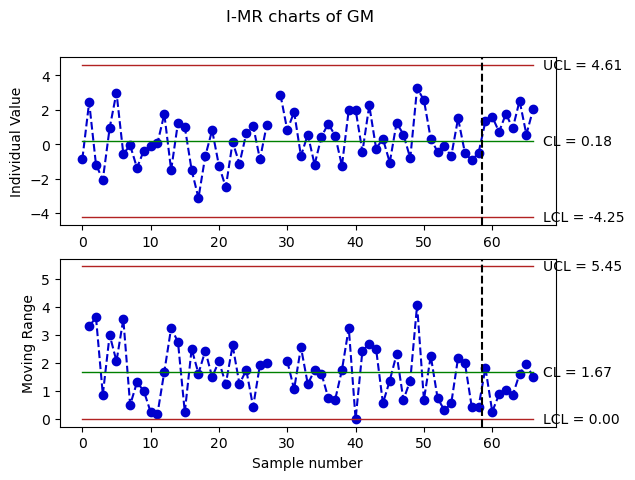

In [68]:
# Import the dataset
data = pd.read_csv('./Lab6/ESE06_ex3.csv')
# replace the OOC point with NaN
data[COL_NAME].iloc[OOC_idx] = np.nan

# Define the array with the new observations
new_obs = np.array((1.327, 1.594, 0.716, 1.767, 0.915, 2.524, 0.563, 2.053))
# Add the new observations to the dataset
new_data = pd.concat([data, pd.DataFrame(new_obs, columns=['GM'])], ignore_index=True)

# Use the parameter `subset_size` to specify the number of observations to be used 
# for the computation of the control limits (Phase 1 data).
new_data_IMR = qda.ControlCharts.IMR(new_data, 'GM', subset_size=len(data))
# chart built only on old data, but new data plotted to see if in control
# black dotted line to separate old and new obs

# ■ SPC non iid (Lab 7)
When we see a trend or strange patterns in a control chart we build, it is probably due to a violation of the assumptions. That's why we should always check them.  

Anyway, in such cases the idea is to 
- fit a model on the data
- extract the residuals
- build a chart on the residuals  

if we believe that there is really a trend/behaviour in the data.  

All this part is related to the case n=1.   
So it is when we do the classical IMR chart code but we see a strange pattern in the chart.

## Regression model (LM)

     I     MR
0  600    NaN
1  480  120.0
2  540   60.0
3  240  300.0
4  420  180.0
     I     MR     I_UCL      I_CL   I_LCL    MR_UCL  MR_CL  MR_LCL  I_TEST1  \
0  600    NaN  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
1  480  120.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
2  540   60.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
3  240  300.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
4  420  180.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   

   MR_TEST1  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


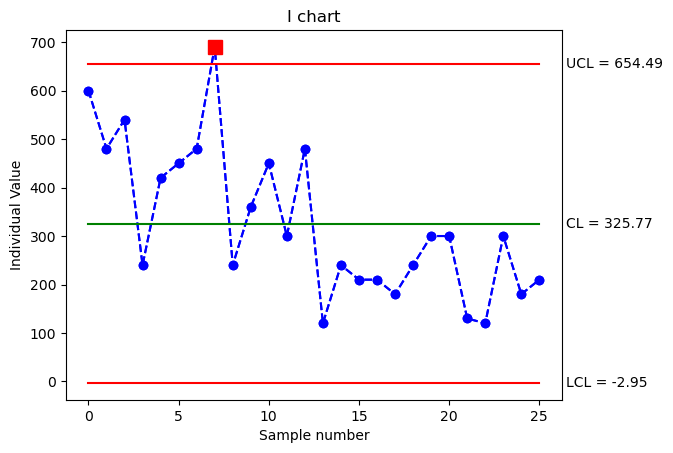

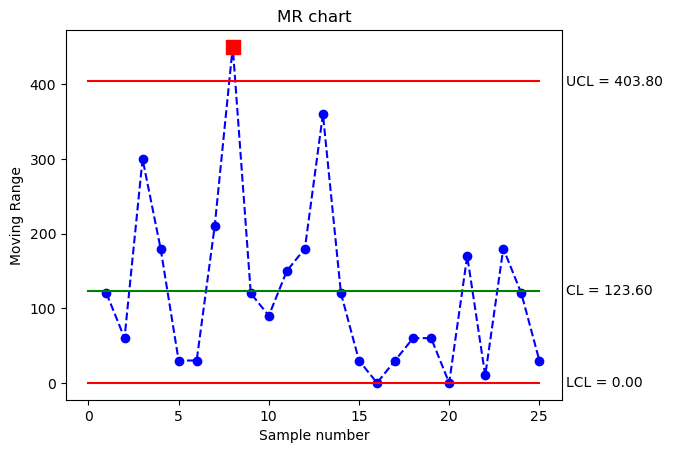

In [55]:
data = pd.read_csv("./Lab7/ESE7_ex1.csv")

###### taken from IMR section above
COL_NAME = "time"
# Compute the moving ranges using the diff function
data['MR'] = data[COL_NAME].diff().abs()
# Print out descriptive statistics of MR and time
# data.describe()

# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

print(df.head())

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

We see something strange so we try to fit a model.  
Indeed the assumptions were not satisfied:

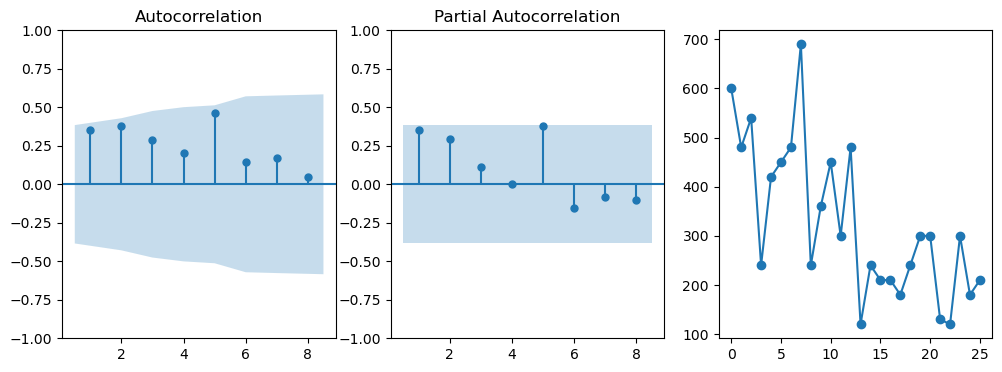

() Runs test p-value = 0.024475950275723145 - Random data at alpha 5%? False
H0 is "data are random" => conclusion is good if pvalue is high


In [58]:
check_randomness(data[COL_NAME])

In [27]:
# Add a column with the sample number to use as regressor
data['t'] = np.arange(1, len(data)+1)
print(data.head())

# Fit linear regression model
x = data['t']
x = sm.add_constant(x)
y = data['time']
model = sm.OLS(y,x).fit()

# Print model summary
qda.summary(model)

   time     MR  t
0   600    NaN  1
1   480  120.0  2
2   540   60.0  3
3   240  300.0  4
4   420  180.0  5
REGRESSION EQUATION
-------------------
time =  + 518.554 const -14.280 t

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value    P-Value
const 518.5538  45.5680  11.3798 3.7191e-11
    t -14.2803   2.9506  -4.8397 6.2424e-05

MODEL SUMMARY
-------------
       S   R-sq  R-sq(adj)
112.8402 0.4939     0.4728

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value    P-Value
Regression  1.0 2.9824e+05 2.9824e+05  23.4232 6.2424e-05
     const  1.0 1.6489e+06 1.6489e+06 129.4994 3.7191e-11
         t  1.0 2.9824e+05 2.9824e+05  23.4232 6.2424e-05
     Error 24.0 3.0559e+05 1.2733e+04      NaN        NaN
     Total 25.0 6.0383e+05        NaN      NaN        NaN


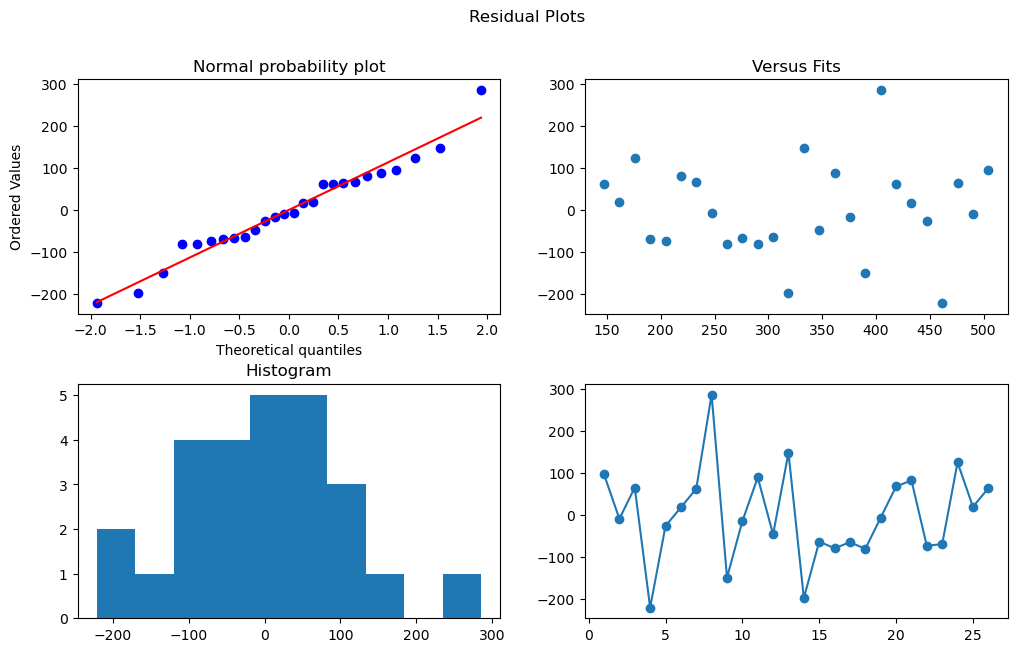

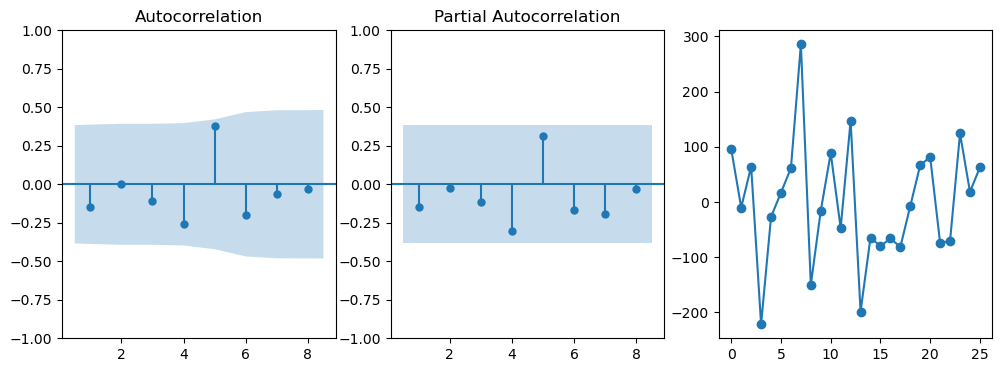

() Runs test p-value = 0.7100281378519226 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
Shapiro-Wilk test p-value on the residuals = 0.700


In [28]:
check_residuals(model)

### Trend chart
A TREND control chart will be based on the residuals of the trend model. And let's use the MR of the residuals.
$$UCL = \color{blue}\big(\beta_0 + \beta_1 \cdot t\big) \color{black}+ 3 \frac{\bar{MR}}{d_2 (2)}$$
$$CL = \color{blue}\big(\beta_0 + \beta_1 \cdot t\big) \color{black}$$
$$LCL = \color{blue}\big(\beta_0 + \beta_1 \cdot t \big) \color{black}- 3 \frac{\bar{MR}}{d_2 (2)}$$


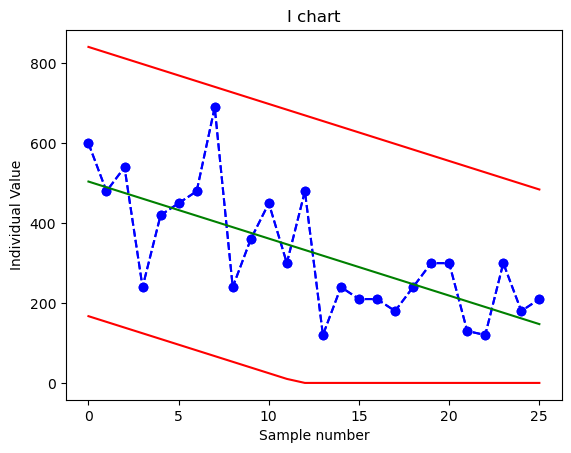

In [33]:
df_res = pd.DataFrame({'I': model.resid})
df_res['MR'] = df_res['I'].diff().abs() # we use the MR of the residuals

# Let's reuse the old dataframe df
# Replace the I_CL column with the fitted values
df['I_CL'] = model.fittedvalues

d2 = qda.constants.getd2(2)
D4 = qda.constants.getD4(2)
# Replace the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * df_res['MR'].mean() / d2
df['I_LCL'] = df['I_CL'] - 3 * df_res['MR'].mean() / d2

# correction if values for their nature cant go below zero (for example)
df['I_LCL'] = np.where((df['I_LCL'] < 0), 0, df['I_LCL'])
# or similar correction wrt the variable at test

# Also update the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

### SCC
Special Cause control Chart. It carries the same information of the trend chart, but the trend gets complex to plot for complex trends, so this is more general, being the classical IMR on residuals.

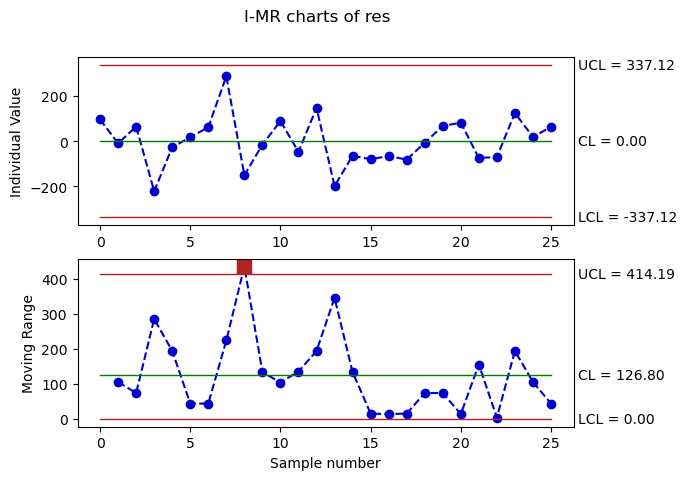

In [47]:
df_res = pd.DataFrame({'res': model.resid})
data_IMR = qda.ControlCharts.IMR(df_res, 'res')

### Dummy variable
Now assume **we found an assignable cause** for the OOC observation 8.  
 (if ass cause not found dont do this dummy procedure).   
We need to redesign the control charts by inserting a DUMMY VARIABLE such that:
- $\text{dummy} = 0$ for $t \neq 8$
- $\text{dummy} = 1$ for $t = 8$

and we refit the model.

   time     MR  t  dummy
0   600    NaN  1      0
1   480  120.0  2      0
2   540   60.0  3      0
3   240  300.0  4      0
4   420  180.0  5      0
REGRESSION EQUATION
-------------------
time =  + 491.459 const -13.138 t + 303.648 dummy

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value    P-Value
const 491.4591  40.4001  12.1648 1.6827e-11
    t -13.1384   2.5785  -5.0953 3.6839e-05
dummy 303.6483 100.5632   3.0195 6.1044e-03

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
97.5439 0.6376     0.6061

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value    P-Value
Regression  2.0 3.8499e+05 1.9250e+05  20.2313 8.5294e-06
     const  1.0 1.4080e+06 1.4080e+06 147.9824 1.6827e-11
         t  1.0 2.4702e+05 2.4702e+05  25.9620 3.6839e-05
     dummy  1.0 8.6749e+04 8.6749e+04   9.1172 6.1044e-03
     Error 23.0 2.1884e+05 9.5148e+03      NaN        NaN
     Total 25.0 6.0383e+05        NaN      NaN        NaN


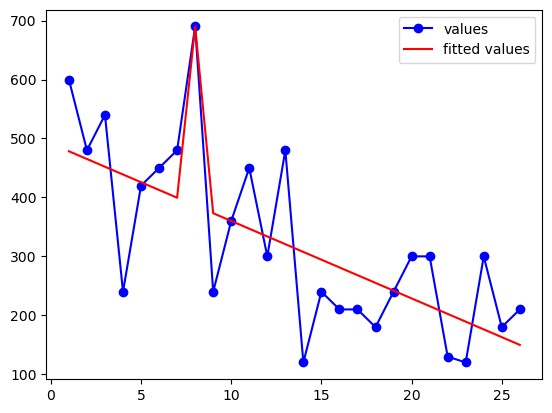

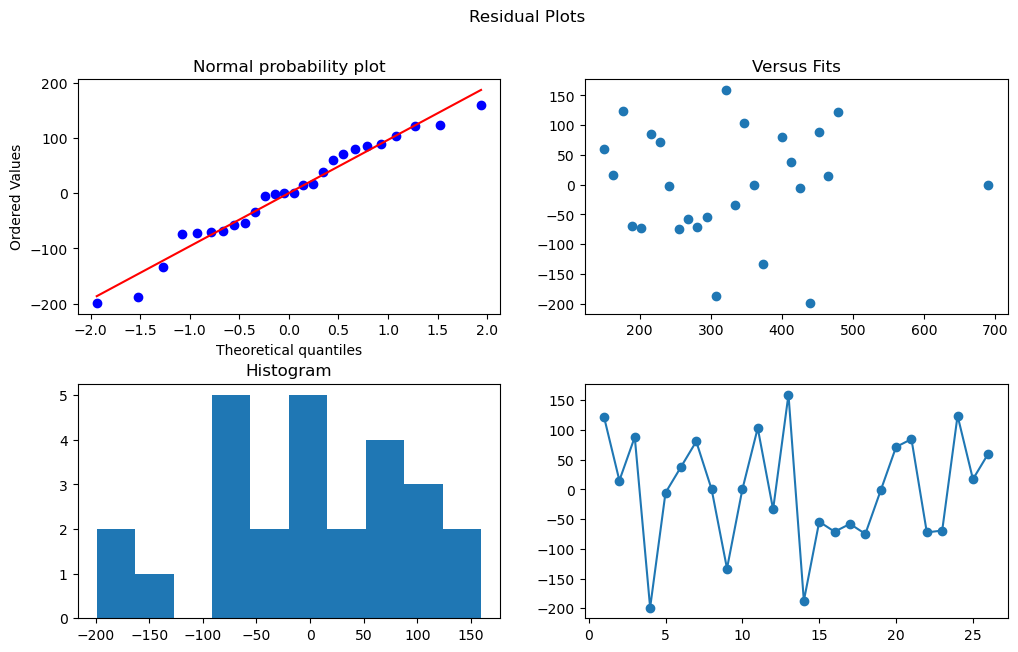

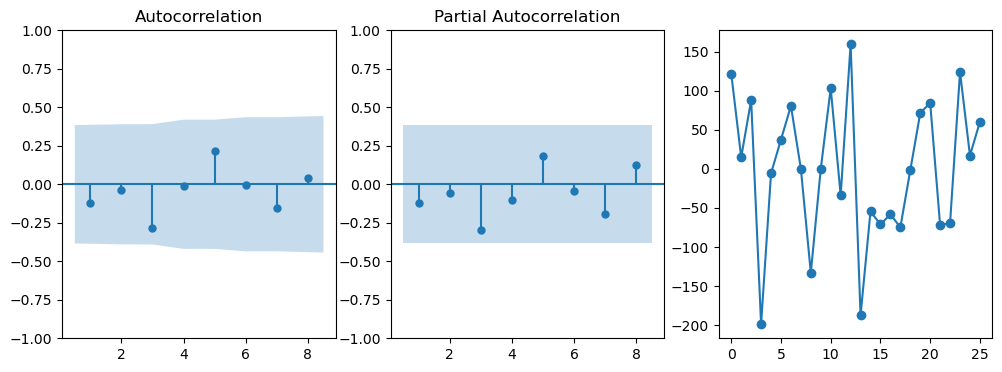

() Runs test p-value = 0.22976627046113807 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
Shapiro-Wilk test p-value on the residuals = 0.530
H0 is "data are not gaussian" => conclusion is good if pvalue is high


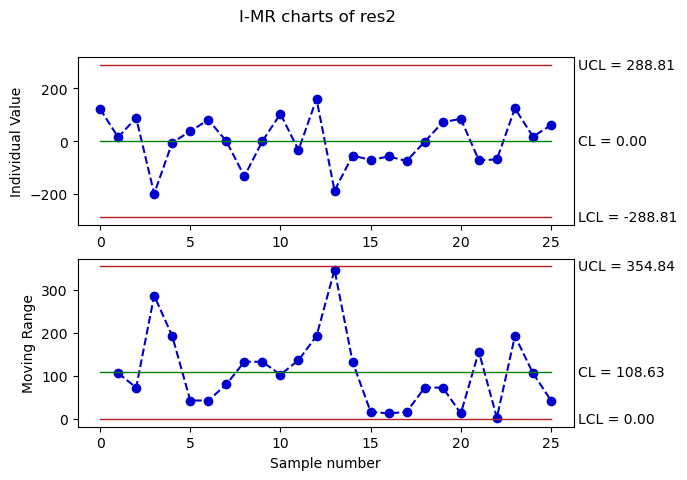

In [45]:
# Create the dummy variable X
data['dummy'] = np.where((data['t'] == 8), 1, 0)
print(data.head())

# re-Fit a model
x = data[['t', 'dummy']]
x = sm.add_constant(x)
y = data['time']
model2 = sm.OLS(y,x).fit()
qda.summary(model2)

plt.plot(data['t'],data['time'], label="values",color='b', linestyle='-', marker='o')
plt.plot(data['t'], model2.fittedvalues, label="fitted values",color='r')
plt.legend()
plt.show()

check_residuals(model2)

# Make a new dataframe for the new residuals
df_res2 = pd.DataFrame({'res2': model2.resid})
# Create the IMR chart
df_res2 = qda.ControlCharts.IMR(df_res2, 'res2')

## Time series models

     I   MR
0  200  NaN
1  202  2.0
2  208  6.0
3  204  4.0
4  204  0.0
     I   MR     I_UCL      I_CL     I_LCL  MR_UCL   MR_CL  MR_LCL  I_TEST1  \
0  200  NaN  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
1  202  2.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
2  208  6.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
3  204  4.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
4  204  0.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   

   MR_TEST1  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


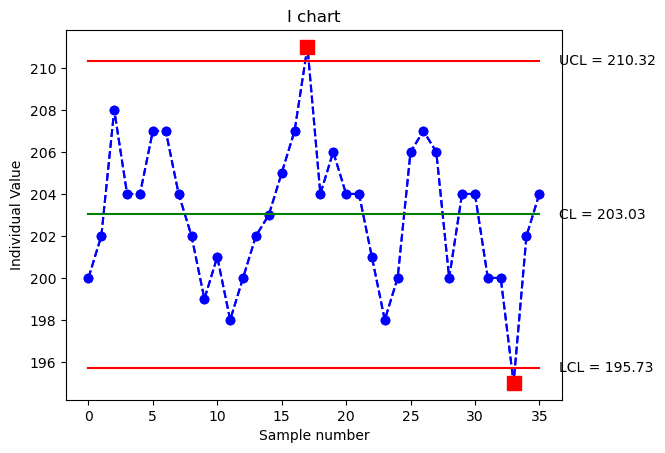

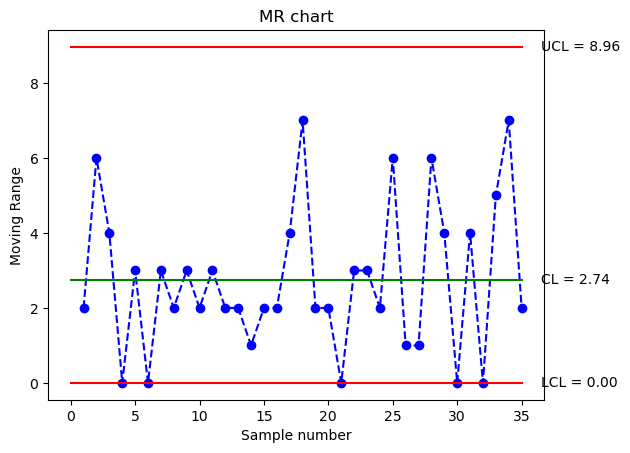

In [59]:
data = pd.read_csv("./Lab7/ESE7_ex2.csv")

###### taken from IMR section above
COL_NAME = "temp"
# Compute the moving ranges using the diff function
data['MR'] = data[COL_NAME].diff().abs()
# Print out descriptive statistics of MR and time
# data.describe()

# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

print(df.head())

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

We see something strange so we try to fit a model.  
Indeed the assumptions were not satisfied:

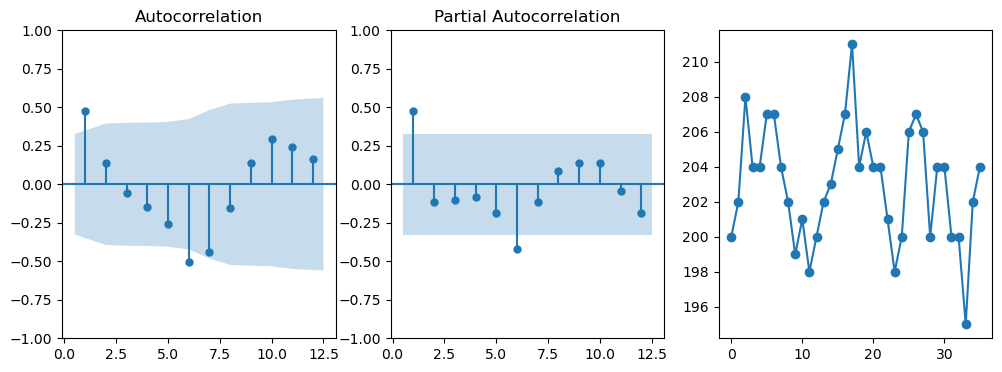

() Runs test p-value = 0.0024081436755146097 - Random data at alpha 5%? False
H0 is "data are random" => conclusion is good if pvalue is high


In [60]:
check_randomness(data[COL_NAME])

> if ACF shows exp decay  $\implies$ AR(p) where p the significance index in PACF  
> if PACF shows exp decay $\implies$ MA(q) where q the significance index in ACF

So there for example seems suitable an AR(1).

   temp   MR  temp_lag1
0   200  NaN        NaN
1   202  2.0      200.0
2   208  6.0      202.0
3   204  4.0      208.0
4   204  0.0      204.0
REGRESSION EQUATION
-------------------
temp =  + 105.800 const + 0.479 temp_lag1

COEFFICIENTS
------------
     Term     Coef  SE Coef  T-Value  P-Value
    const 105.7999  30.5748   3.4604   0.0015
temp_lag1   0.4794   0.1506   3.1833   0.0032

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
2.9664 0.2349     0.2117

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS  F-Value  P-Value
Regression  1.0  89.1649  89.1649  10.1332   0.0032
     const  1.0 105.3642 105.3642  11.9741   0.0015
 temp_lag1  1.0  89.1649  89.1649  10.1332   0.0032
     Error 33.0 290.3779   8.7993      NaN      NaN
     Total 34.0 379.5429      NaN      NaN      NaN


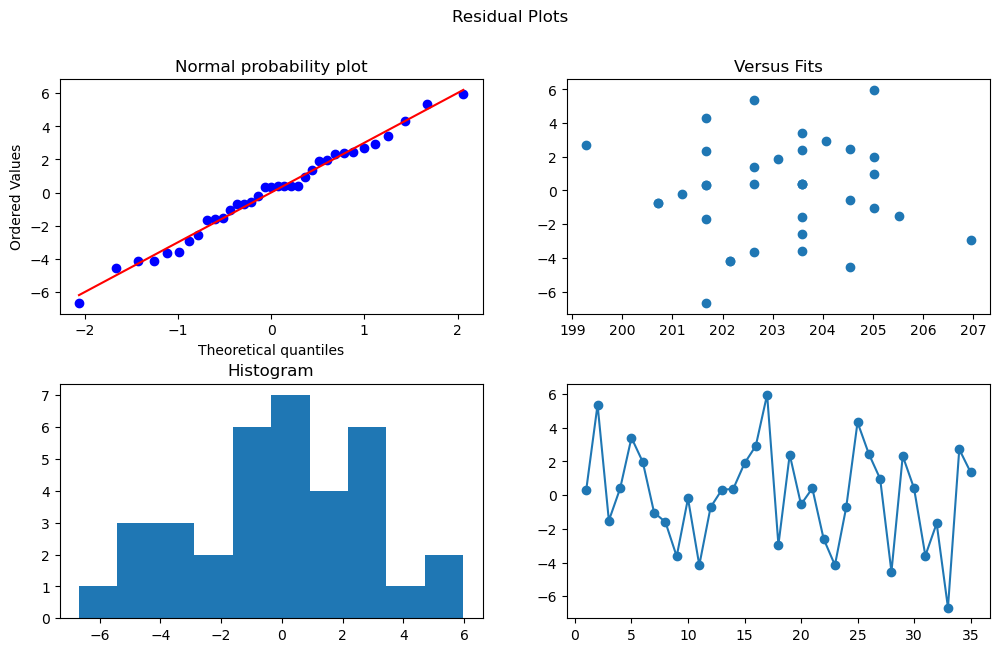

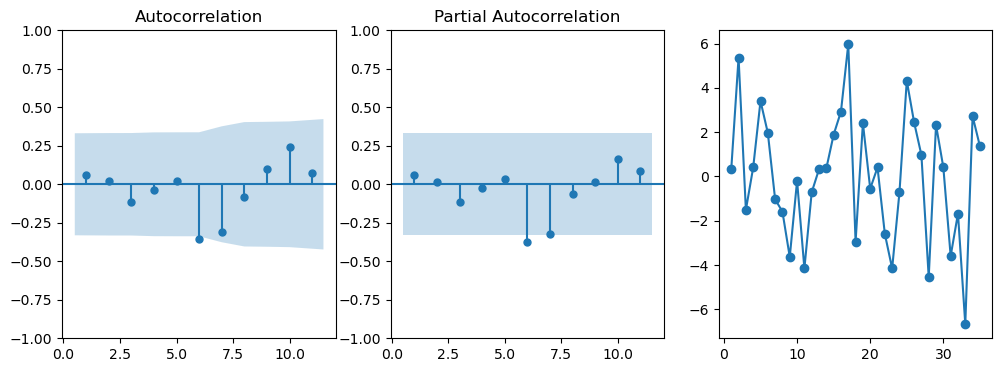

(residuals) Runs test p-value = 0.2437297147615337 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(residuals) Normality p-value = 0.9538149237632751 - Normality at alpha 5%? True
H0 is "data are not gaussian" => conclusion is good if pvalue is high


In [67]:
# Add a column with the lagged temperature to use as regressor
data['temp_lag1'] = data['temp'].shift(1)
print(data.head())
# Fit the linear regression model
import statsmodels.api as sm
x = data['temp_lag1'][1:]
x = sm.add_constant(x) # this command is used to consider a constant to the model,
y = data['temp'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

check_residuals(model)

### SCC

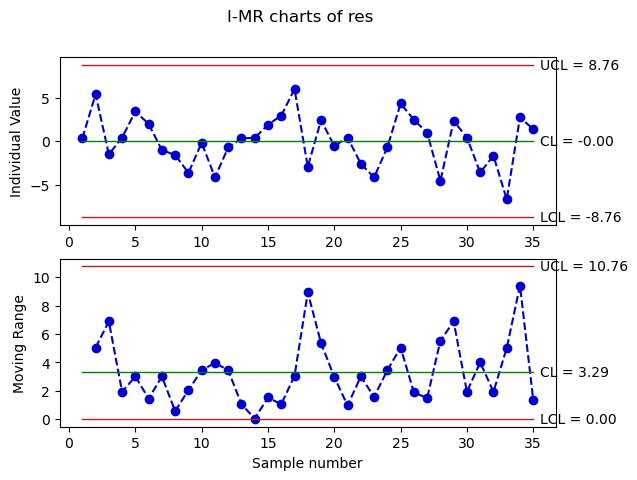

In [68]:
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])
# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

### FVC

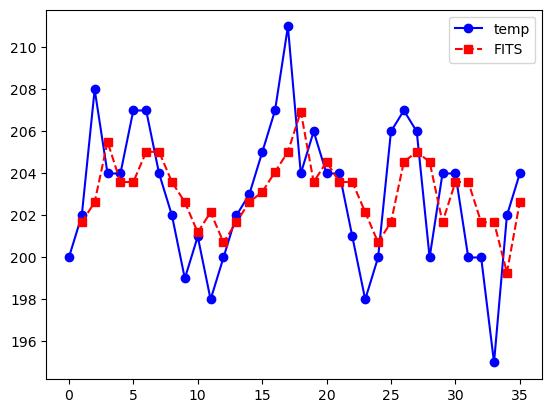

In [69]:
plt.plot(data['temp'], color='b', linestyle='-', marker='o', label='temp')
plt.plot(model.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

### Trend chart

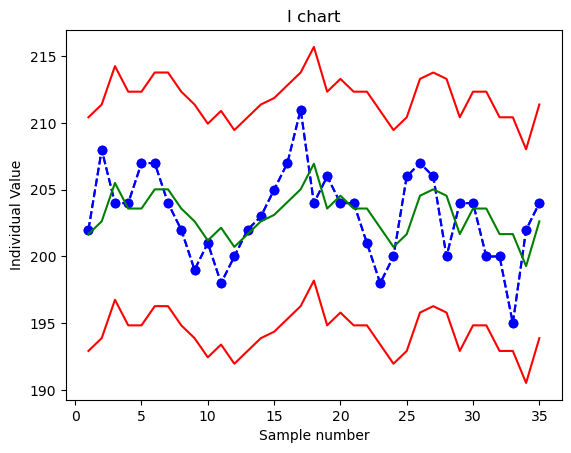

In [71]:
d2 = qda.constants.getd2(2)
MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': data['temp'].iloc[1:], 'I_CL': model.fittedvalues}, index=data.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

## Case n>1 and unstackable
(or IMR-R charts)

In the case n>1, if we know the within sample order we can just stack the data, creating the big vector, and we proceed as before.  
Instead if we dont know it the XbarR charts may be inappropriate if there is violation of assumption of independence within the samples. We see it from the control limits of the Xbar chart looking to narrow with respect to the natural variabilty of the statistic.  

**Solution**: design
- a "between groups" control chart (MR chart), and 
- a "within groups" control chart (R chart) 

    x1   x2   x3   x4
0  456  458  439  448
1  459  462  495  500
2  443  453  457  458
3  470  450  478  470
4  457  456  460  457


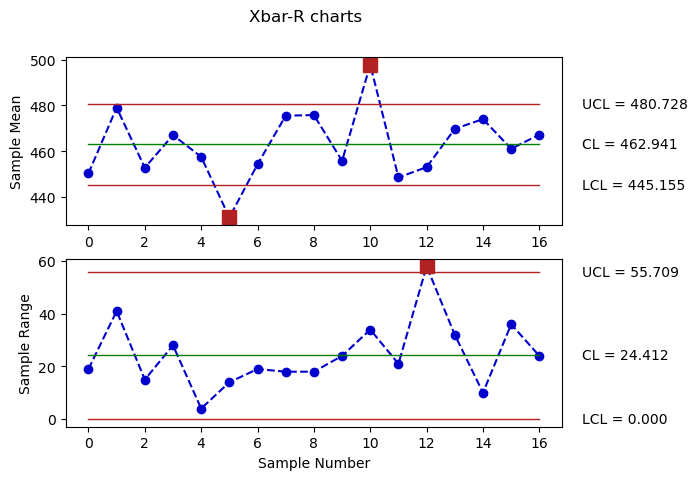

In [83]:
# Import the dataset
data = pd.read_csv('./Lab7/ESE7_ex3.csv')
# Inspect the dataset
print(data.head())

data_XR = qda.ControlCharts.XbarR(data)

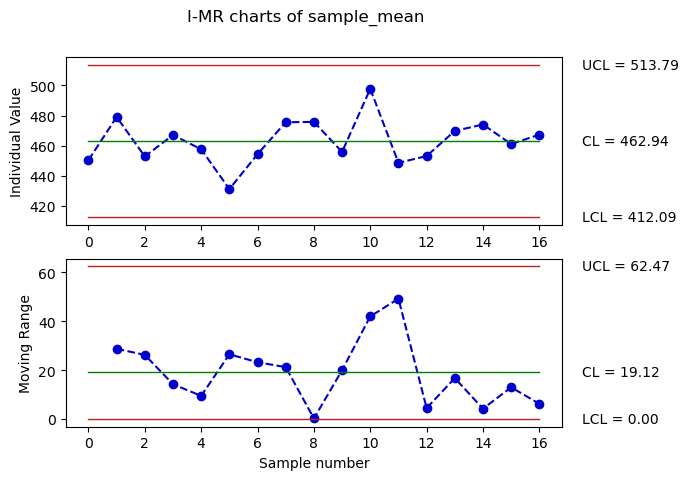

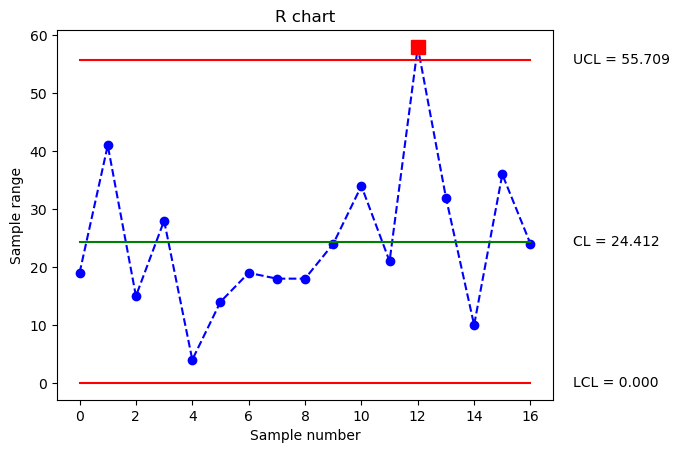

In [86]:
# Design a I-MR-R control chart
# Build the IMR chart using this new dataframe
data_Xbar = qda.ControlCharts.IMR(data_Xbar, 'sample_mean')

# Plot the R chart as well
plt.title('R chart')
plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['R_UCL'], color='r')
plt.plot(data_XR['R_CL'], color='g')
plt.plot(data_XR['R_LCL'], color='r')
plt.ylabel('Sample range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# ■ Multivariate SPC (Lab 8)

In [6]:
# Import the dataset
data = pd.read_csv('Lab8/ESE8_ex1.csv')
data.head()

,Boat,Width1,Width2,Width3,Corr.speed1,Corr.speed2,Corr.speed3
0,1,2.14,2.01,1.88,0.33,0.47,0.50
1,2,1.96,1.91,1.94,0.37,0.62,0.37
2,3,1.93,1.86,1.99,0.54,0.57,0.39
3,4,1.94,1.96,1.86,0.52,0.45,0.72
4,5,1.94,2.13,2.17,0.66,0.53,0.33


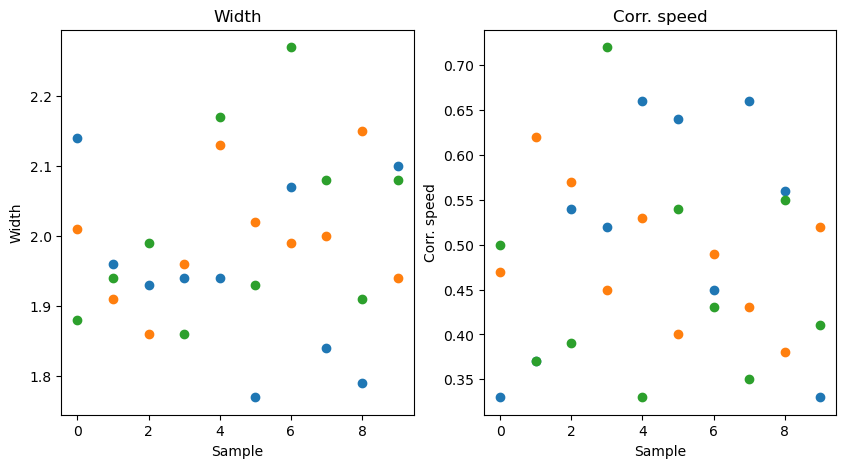

In [11]:
# Extract the stacked array
COVA1 = data[['Width1', 'Width2', 'Width3']]
COVA2 = data[['Corr.speed1', 'Corr.speed2', 'Corr.speed3']]

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(COVA1, 'o')
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Width')
ax[0].set_title('Width')
ax[1].plot(COVA2, 'o')
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Corr. speed')
ax[1].set_title('Corr. speed')
plt.show()

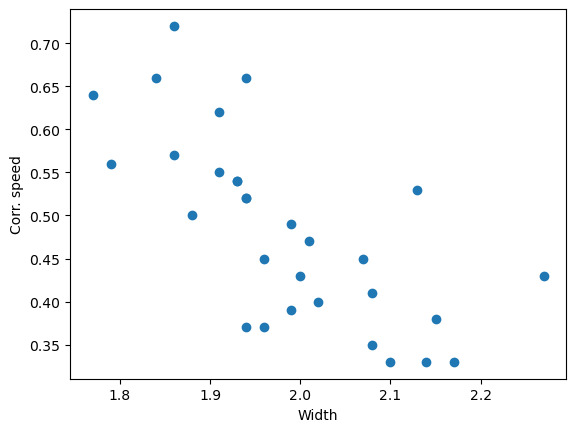

In [12]:
# Plot the stacked-covariates, to see correlation
# if there is correlation -> multivariate charts should be better
plt.scatter(COVA1, COVA2)
plt.xlabel('Width')
plt.ylabel('Corr. speed')
plt.show()